In [1]:
import pandas as pd
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.nn.utils import clip_grad_norm_
import re
from collections import Counter
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ------------------------
# 1. Load and preprocess data
# ------------------------
data_list = []
with open("general_data.json", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            data_list.append(json.loads(line))

df = pd.DataFrame(data_list)

# Improved text preprocessing
def preprocess_text(text):
    """Enhanced text preprocessing"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters but keep punctuation that might be meaningful
    text = re.sub(r'[^\w\s.,!?;:]', ' ', text)
    
    return text.strip()

In [2]:
# Apply preprocessing and combine text
df['user_query_clean'] = df['user_query'].apply(preprocess_text)
df['chatgpt_response_clean'] = df['chatgpt_response'].apply(preprocess_text)

# Create separate features and combined text
df['text'] = df['user_query_clean'] + " [SEP] " + df['chatgpt_response_clean']
df['query_length'] = df['user_query_clean'].str.len()
df['response_length'] = df['chatgpt_response_clean'].str.len()

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# ------------------------
# 2. Handle class imbalance
# ------------------------
le = LabelEncoder()
df['label'] = le.fit_transform(df['hallucination'])

# Check class distribution
class_counts = Counter(df['label'])

Dataset shape: (4507, 10)
Columns: ['ID', 'user_query', 'chatgpt_response', 'hallucination', 'hallucination_spans', 'user_query_clean', 'chatgpt_response_clean', 'text', 'query_length', 'response_length']


In [3]:
print(f"Class distribution: {dict(class_counts)}")

# Calculate class weights for balanced training
class_weights = torch.tensor([
    1.0 / class_counts[0] * len(df) / 2,
    1.0 / class_counts[1] * len(df) / 2
], dtype=torch.float)

# ------------------------
# 3. Enhanced tokenization
# ------------------------
MAX_VOCAB = 50000  # Increased vocabulary
MAX_LEN = 512      # Increased sequence length

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>", char_level=False)
tokenizer.fit_on_texts(df['text'].tolist())

sequences = tokenizer.texts_to_sequences(df['text'].tolist())
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Average sequence length: {np.mean([len(seq) for seq in sequences]):.2f}")

# ------------------------
# 4. Stratified train/validation/test split
# ------------------------
# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    padded_sequences, df['label'].values, 
    test_size=0.15, random_state=42, stratify=df['label']
)

# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

Class distribution: {0: 3692, 1: 815}
Vocabulary size: 21391
Average sequence length: 97.03


In [4]:
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# ------------------------
# 5. Enhanced PyTorch Dataset
# ------------------------
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ------------------------
# 6. Enhanced BiLSTM Model with Attention
# ------------------------
class AttentionBiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=2, dropout=0.4):
        super(AttentionBiLSTMClassifier, self).__init__()
        
        # Embedding layer with dropout
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embed_dropout = nn.Dropout(dropout)
        
        # BiLSTM layers
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, 
            num_layers=n_layers, 
            bidirectional=True, 
            batch_first=True, 
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        
        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        x = self.embed_dropout(x)
        
        # BiLSTM
        lstm_out, _ = self.lstm(x)
        
        # Self-attention
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global max pooling and global average pooling
        max_pool = torch.max(attn_out, dim=1)[0]
        avg_pool = torch.mean(attn_out, dim=1)
        
        # Concatenate pooled features
        pooled = max_pool + avg_pool  # Element-wise addition instead of concat
        
        # Batch normalization
        if pooled.size(0) > 1:  # Only apply batch norm if batch size > 1
            pooled = self.batch_norm(pooled)
        
        # Classification
        out = self.classifier(pooled)
        return torch.sigmoid(out)

# ------------------------
# 7. Initialize model with better parameters
# ------------------------
VOCAB_SIZE = 50000
EMBED_DIM = 256  # Increased embedding dimension
HIDDEN_DIM = 256  # Increased hidden dimension
OUTPUT_DIM = 1

model = AttentionBiLSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, n_layers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
class_weights = class_weights.to(device)

print(f"Using device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Train size: 3155, Val size: 675, Test size: 677
Using device: cuda
Model parameters: 16,645,633


In [5]:
criterion = nn.BCELoss()

# Better optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.5, verbose=True
)

# ------------------------
# 9. Enhanced training loop with early stopping
# ------------------------
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return total_loss / len(data_loader), accuracy, f1

EPOCHS = 20
best_val_f1 = 0
patience_counter = 0
patience = 7

train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
        
        # Apply class weights to loss
        pos_weight = class_weights[1] if y_batch.sum() > 0 else 1.0
        weighted_criterion = nn.BCELoss(weight=torch.ones_like(y_batch) * pos_weight)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = weighted_criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_train_loss += loss.item()
    
    # Validation
    val_loss, val_acc, val_f1 = evaluate_model(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_f1)
    
    # Store metrics
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  New best F1: {best_val_f1:.4f} - Model saved!")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

# ------------------------
# 10. Load best model and final evaluation
# ------------------------
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc, test_f1 = evaluate_model(model, test_loader, criterion, device)

print("\n" + "="*50)
print("FINAL TEST RESULTS")
print("="*50)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Detailed classification report
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
        outputs = model(X_batch)
        preds = (outputs > 0.5).float()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

c:\Users\SARTHAK\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...
Epoch 1/20
  Train Loss: 1.4257
  Val Loss: 0.4690, Val Acc: 0.8193, Val F1: 0.0000
  LR: 0.000200
  Patience: 1/7
Epoch 2/20
  Train Loss: 1.2782
  Val Loss: 0.4565, Val Acc: 0.8222, Val F1: 0.0625
  LR: 0.000200
  New best F1: 0.0625 - Model saved!
Epoch 3/20
  Train Loss: 1.2002
  Val Loss: 0.5301, Val Acc: 0.8193, Val F1: 0.0000
  LR: 0.000200
  Patience: 1/7
Epoch 4/20
  Train Loss: 1.1373
  Val Loss: 0.5676, Val Acc: 0.8000, Val F1: 0.0690
  LR: 0.000200
  New best F1: 0.0690 - Model saved!
Epoch 5/20
  Train Loss: 1.0423
  Val Loss: 0.5283, Val Acc: 0.8059, Val F1: 0.2339
  LR: 0.000200
  New best F1: 0.2339 - Model saved!
Epoch 6/20
  Train Loss: 0.9832
  Val Loss: 0.5878, Val Acc: 0.8000, Val F1: 0.2781
  LR: 0.000200
  New best F1: 0.2781 - Model saved!
Epoch 7/20
  Train Loss: 0.9242
  Val Loss: 0.8303, Val Acc: 0.8237, Val F1: 0.0775
  LR: 0.000200
  Patience: 1/7
Epoch 8/20
  Train Loss: 0.8830
  Val Loss: 1.2474, Val Acc: 0.8237, Val F1: 0.0480
  LR: 

C:\Users\SARTHAK\AppData\Local\Temp\ipykernel_24224\3293882212.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



FINAL TEST RESULTS
Test Accuracy: 0.7858
Test F1 Score: 0.3256

Detailed Classification Report:
              precision    recall  f1-score   support

          no       0.85      0.90      0.87       555
         yes       0.38      0.29      0.33       122

    accuracy                           0.79       677
   macro avg       0.61      0.59      0.60       677
weighted avg       0.77      0.79      0.77       677


Confusion Matrix:
[[497  58]
 [ 87  35]]


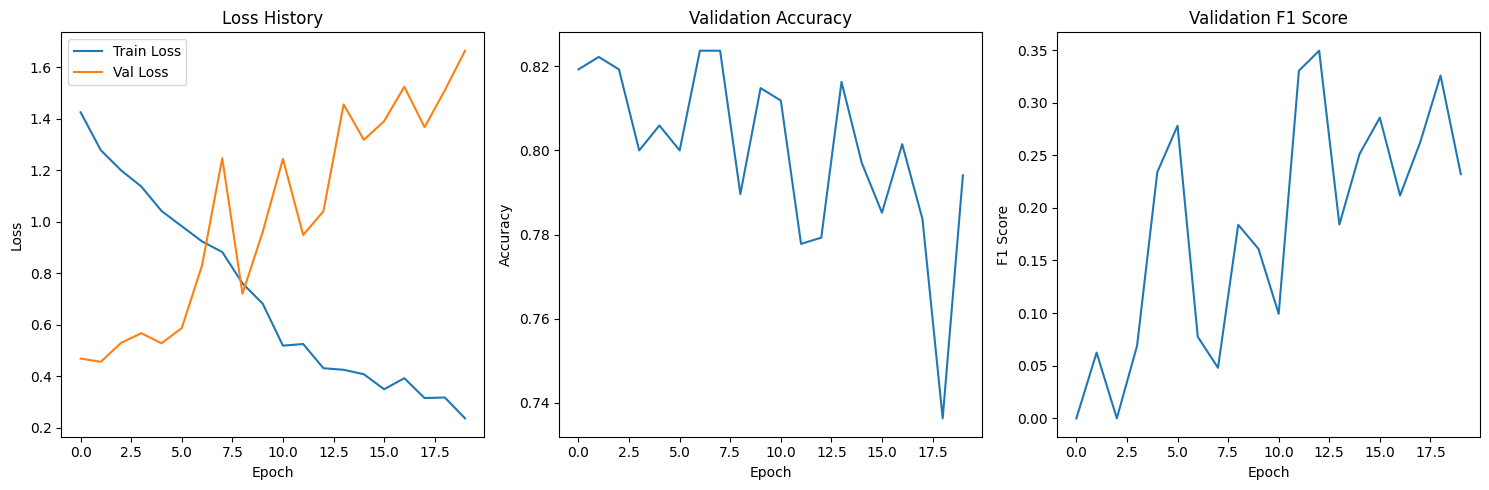


Best validation F1 score: 0.3493
Training completed!


In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(val_f1_scores, label='Val F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ------------------------
# 11. Feature importance analysis (optional)
# ------------------------
def analyze_predictions(model, tokenizer, texts, labels, preds, probs, num_examples=5):
    """Analyze model predictions on specific examples"""
    print("\n" + "="*80)
    print("PREDICTION ANALYSIS")
    print("="*80)
    
    # Show some correct and incorrect predictions
    correct_mask = (np.array(preds).flatten() == np.array(labels).flatten())
    incorrect_indices = np.where(~correct_mask)[0]
    correct_indices = np.where(correct_mask)[0]
    
    print(f"\nIncorrect Predictions (showing first {min(num_examples, len(incorrect_indices))}):")
    for i in incorrect_indices[:num_examples]:
        print(f"\nExample {i}:")
        print(f"Text: {texts[i][:200]}...")
        print(f"True Label: {le.classes_[int(labels[i])]}")
        print(f"Predicted: {le.classes_[int(preds[i])]}")
        print(f"Probability: {probs[i][0]:.4f}")
        print("-" * 50)

# Run analysis if you have the original texts
# analyze_predictions(model, tokenizer, df['text'].iloc[test_indices], all_labels, all_preds, all_probs)

print(f"\nBest validation F1 score: {best_val_f1:.4f}")
print("Training completed!")
